<center><h1> Intelligent Systems </h1>
    <h2> <b>Assignment #1</b> </h2>
    <h3> Done by: Ghinea Cristian and Varga Zoltan </h3></center>

<h3> Abstract </h3>
<p> We decided to examine a dataset which holds data about the shopping habits of citizens living in Istanbul. It holds data related to 10 shopping malls collected between 2021 and 2023. As the authors state it should provide a "comprehensive view of shopping habits in Istanbul".</p>
<p> The model built by us is able to predict <i> the likelihood of someone paying by credit card, debit card or cash. </i></p>
<p> <i>The dataset can be downloaded from here: <a href="https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset"> click here </a></i><p>

In [216]:
# Start by including some essential libraries

import pandas as pd
import numpy as np
import seaborn as sns


from pandas.plotting import scatter_matrix
from seaborn import scatterplot, heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [217]:
# read the dataset
df = pd.read_csv("./dataset/customer_shopping_data.csv")

<h3> Start by taking a look at our data </h3>

<p> 
    Here we can se that the types of the columns are as expected. This fact predicts us that there is no garbage (at least no mix of types within the columns).
</p>

In [218]:
df.columns

Index(['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity',
       'price', 'payment_method', 'invoice_date', 'shopping_mall'],
      dtype='object')

In [219]:
df.dtypes

invoice_no         object
customer_id        object
gender             object
age                 int64
category           object
quantity            int64
price             float64
payment_method     object
invoice_date       object
shopping_mall      object
dtype: object

<p>
    This description gives us a better insight. The first two columns seem to be unique identifiers of the rows as there are as many unique values there as rows. The first decision of ours will be to delete these two columns because unique identifiers don't hold meaningful information.
</p>
<p>
    Going further, the remaining columns seem to have correct data, without any noise. We must mention that the age is neatly distributed, which is promising as this can be an important predictor.
</p>

In [220]:
df.describe(include="all")

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
count,99457,99457,99457,99457.000000,99457,99457.000000,99457.000000,99457,99457,99457
unique,99457,99457,2,NaN,8,NaN,NaN,3,797,10
top,I138884,C241288,Female,NaN,Clothing,NaN,NaN,Cash,24/11/2021,Mall of Istanbul
freq,1,1,59482,NaN,34487,NaN,NaN,44447,159,19943
mean,NaN,NaN,NaN,43.427089,NaN,3.003429,689.256321,NaN,NaN,NaN
std,NaN,NaN,NaN,14.990054,NaN,1.413025,941.184567,NaN,NaN,NaN
min,NaN,NaN,NaN,18.000000,NaN,1.000000,5.230000,NaN,NaN,NaN
25%,NaN,NaN,NaN,30.000000,NaN,2.000000,45.450000,NaN,NaN,NaN
50%,NaN,NaN,NaN,43.000000,NaN,3.000000,203.300000,NaN,NaN,NaN
75%,NaN,NaN,NaN,56.000000,NaN,4.000000,1200.320000,NaN,NaN,NaN


In [221]:
# delete the columns containing unique identifiers
df = df[['gender','age','category','quantity','price','payment_method','invoice_date','shopping_mall']]

In [222]:
# check what categories we have
df['category'].unique()

array(['Clothing', 'Shoes', 'Books', 'Cosmetics', 'Food & Beverage',
       'Toys', 'Technology', 'Souvenir'], dtype=object)

In [223]:
# check the payment methods
df['payment_method'].unique()

array(['Credit Card', 'Debit Card', 'Cash'], dtype=object)

In [224]:
df['shopping_mall'].unique()

array(['Kanyon', 'Forum Istanbul', 'Metrocity', 'Metropol AVM',
       'Istinye Park', 'Mall of Istanbul', 'Emaar Square Mall',
       'Cevahir AVM', 'Viaport Outlet', 'Zorlu Center'], dtype=object)

<p>
    As the names of the malls didn't provide us with any information, we opted to categorize them into two groups: expensive (1) and affordable (0) malls. We conducted research online to distinguish between the two.
</p>

In [225]:
df['mall_category'] = ''
df.loc[df['shopping_mall'] == 'Kanyon','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Forum Istanbul','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Metrocity','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Metropol AVM','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Istinye Park','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Mall of Istanbul','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Emaar Square Mall','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Cevahir AVM','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Viaport Outlet','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Zorlu Center','mall_category'] = 1

In [226]:
# df['gender_num'] = 0
# df.loc[df['gender'] == 'Male', 'gender_num'] = 1

In [227]:
# categorise the years as the prefference of using debit/credit card or cash does not change over 1 year, but over a generation
# we grouped them in 8 year intervals

df['age_cat_1'] = 0
df['age_cat_2'] = 0
df['age_cat_3'] = 0
df['age_cat_4'] = 0
df['age_cat_5'] = 0
df['age_cat_6'] = 0
df['age_cat_7'] = 0

df.loc[df['age'].between(18,25), 'age_cat_1'] = 1
df.loc[df['age'].between(26,33), 'age_cat_2'] = 1
df.loc[df['age'].between(34,41), 'age_cat_3'] = 1
df.loc[df['age'].between(42,49), 'age_cat_4'] = 1
df.loc[df['age'].between(50,57), 'age_cat_5'] = 1
df.loc[df['age'].between(58,65), 'age_cat_6'] = 1
df.loc[df['age'].between(66,73), 'age_cat_7'] = 1

<p> 
    We extracted only the year and the month of the payment, as the day is not relevant. By the month maybe we can observe some patterns regarding high-sale periods such as holidays. At first we wanted to remove the year as well, but we quickly changed our minds as the preference for paying with card over cash drastically changed during the pandemic, and the dataset captures this period.
</p>

In [228]:
df['year'] = pd.to_datetime(df['invoice_date'],format='%d/%m/%Y').dt.year
df['month'] = pd.to_datetime(df['invoice_date'],format='%d/%m/%Y').dt.month

In [229]:
df['price'].describe()

count    99457.000000
mean       689.256321
std        941.184567
min          5.230000
25%         45.450000
50%        203.300000
75%       1200.320000
max       5250.000000
Name: price, dtype: float64

In [230]:
df['payment_method'].unique()

array(['Credit Card', 'Debit Card', 'Cash'], dtype=object)

<p> We observed that we have some outliers in the price column, there are only a few payments above 3250 turkish liras, so we decided to get rid of them.</p> 

In [231]:
df = df[df['price'] <= 3250]

<h3> Separate the test set and the training set </h3>

As in the followings we will dive deeper into the dataset we must lock the test set away. As we have plenty of data we can afford a 80% - 20% ratio between the size of the training and the test set.

In [232]:
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

<h3> Data visualization </h3>

We copied the training set in order not to modify them by chance. We made a scatter plot to visualize the eventual correlation between the columns. Unfortunately we have only a few columns that contain numerical values, so we couldn't draw a conclusion from these plots. But below we combined some features in graphs that we considered important.

In [233]:
copy_dev_df = dev_df.copy()

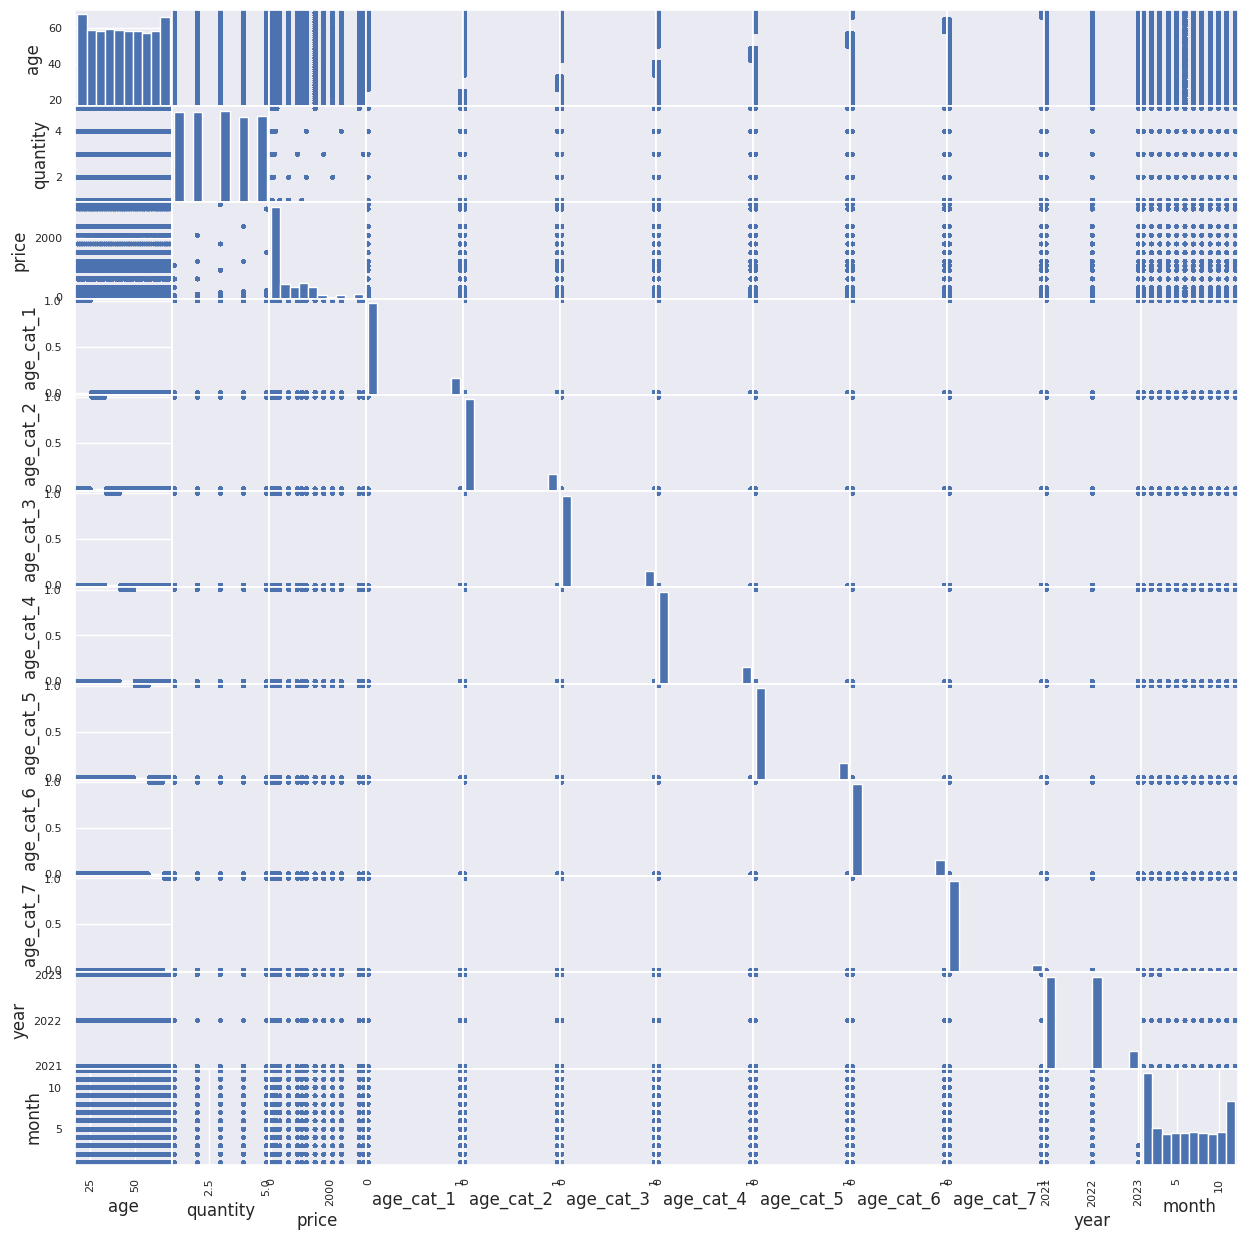

In [234]:
m = scatter_matrix(copy_dev_df,figsize=(15,15))

We suspected a high correlation between the age of a customer and the payment method it will use. So we tried to visualize these two. </p> <p> To our surprise there wasn't a high correlation between the age category and the payment method used. More specifically there is only a subtle change in the number of purchases where cash was used in the 4th and 5th category. This means that we cannot conclude that the young generation is more prone to using card than cash when making a payment.

<Axes: xlabel='age_cat'>

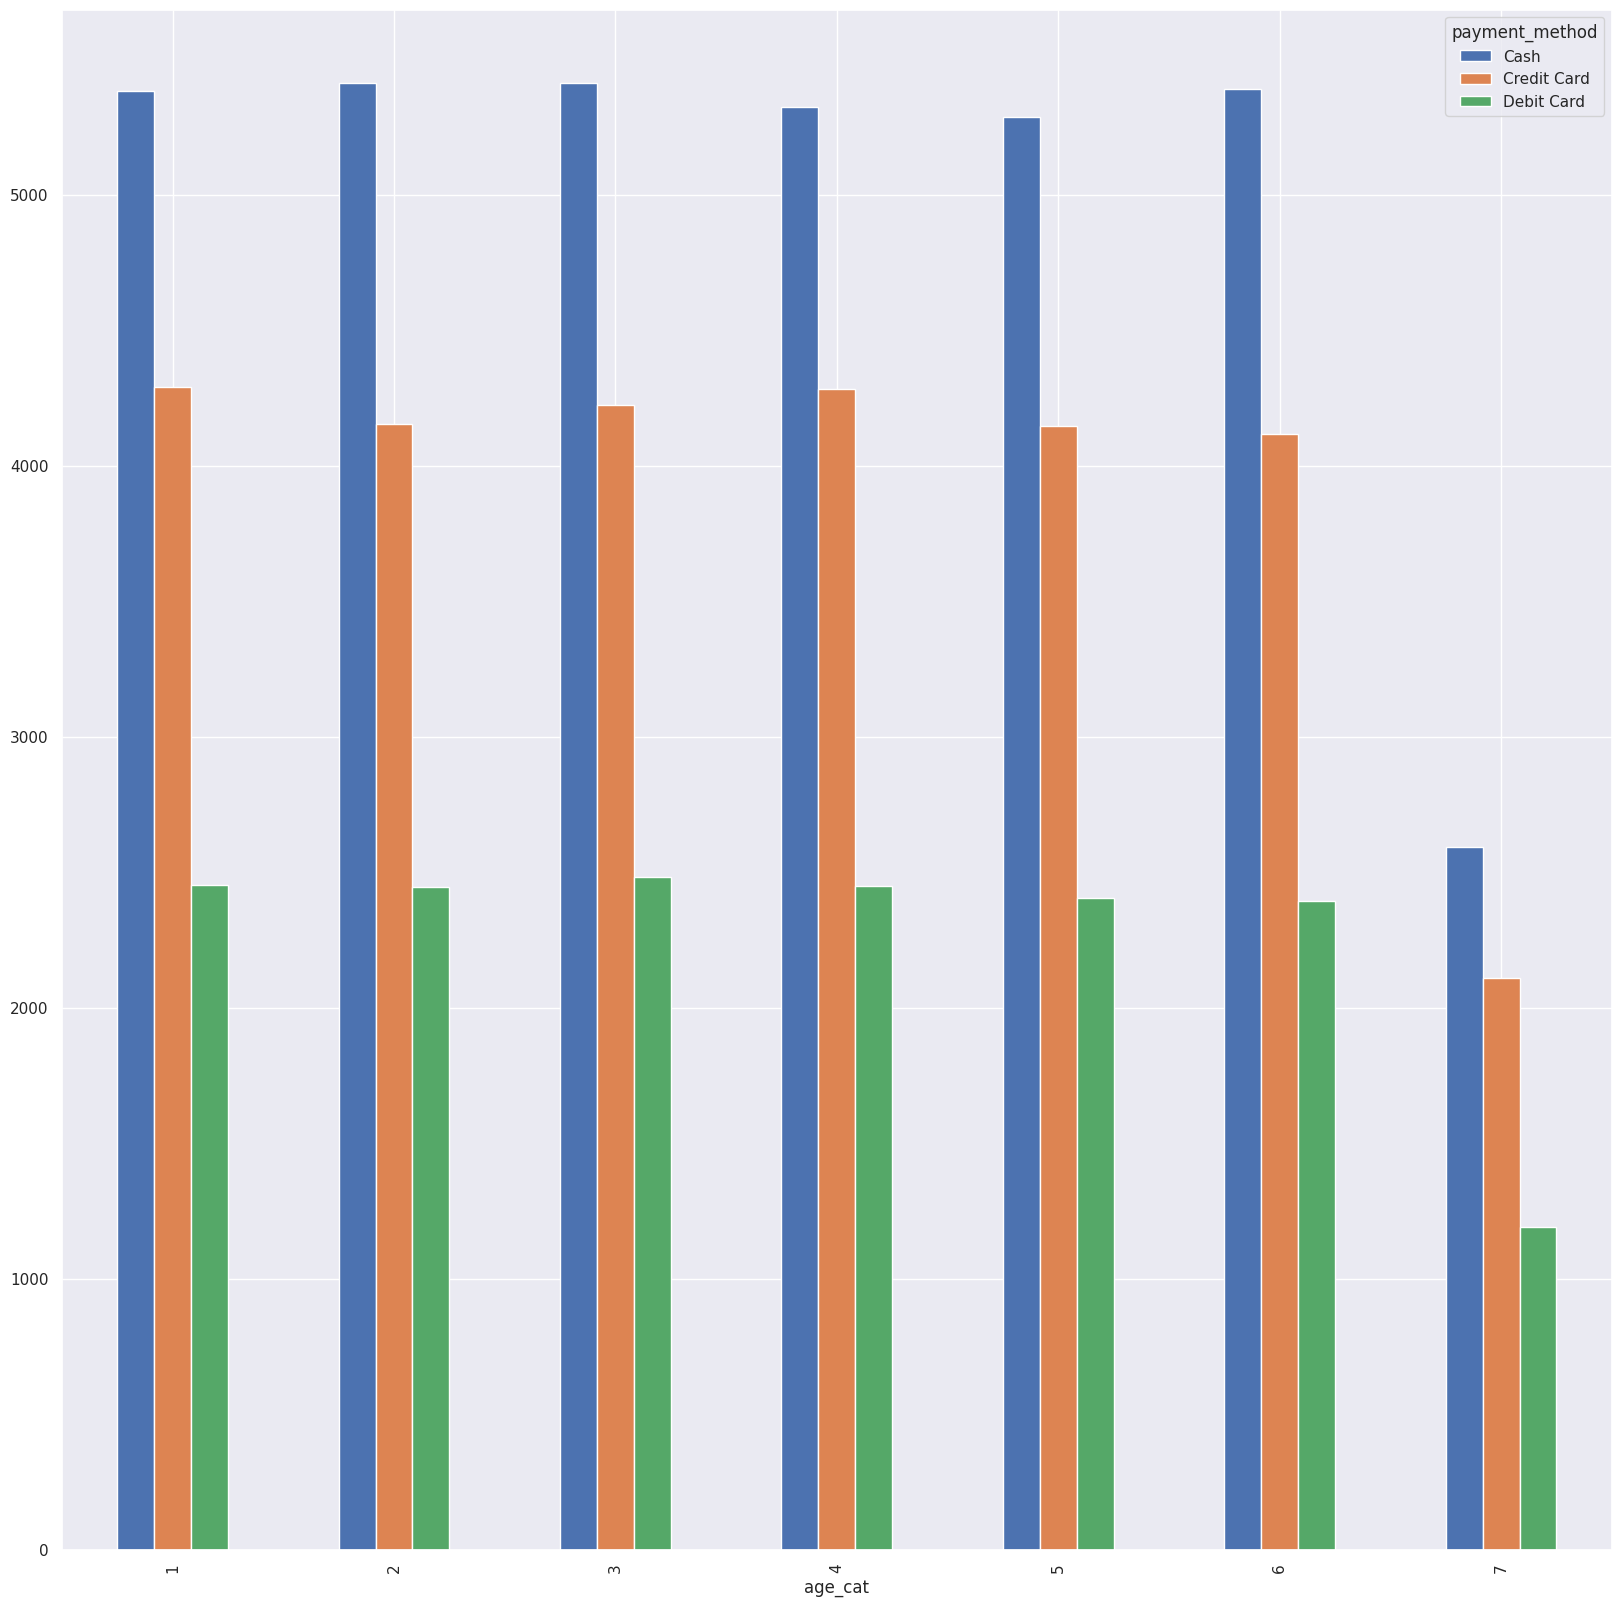

In [235]:
# make the categories in one column, remove that column afterwards
copy_dev_df['age_cat'] = 0
copy_dev_df.loc[copy_dev_df['age'].between(18,25), 'age_cat'] = 1
copy_dev_df.loc[copy_dev_df['age'].between(26,33), 'age_cat'] = 2
copy_dev_df.loc[copy_dev_df['age'].between(34,41), 'age_cat'] = 3
copy_dev_df.loc[copy_dev_df['age'].between(42,49), 'age_cat'] = 4
copy_dev_df.loc[copy_dev_df['age'].between(50,57), 'age_cat'] = 5
copy_dev_df.loc[copy_dev_df['age'].between(58,65), 'age_cat'] = 6
copy_dev_df.loc[copy_dev_df['age'].between(66,73), 'age_cat'] = 7

# Create a pivot table to capture the payment methods used for each age category
age_payment_method_combined = copy_dev_df.pivot_table(index='age_cat', columns='payment_method', aggfunc='count')['age']
# Plot the table
age_payment_method_combined.plot.bar()

<p>The drop in the overall purchases in the 7th age category it is most probably due to the limited number of rows that are covering this age group. Also from the following plot one can see that there is an even distribution of the age groups.</p>

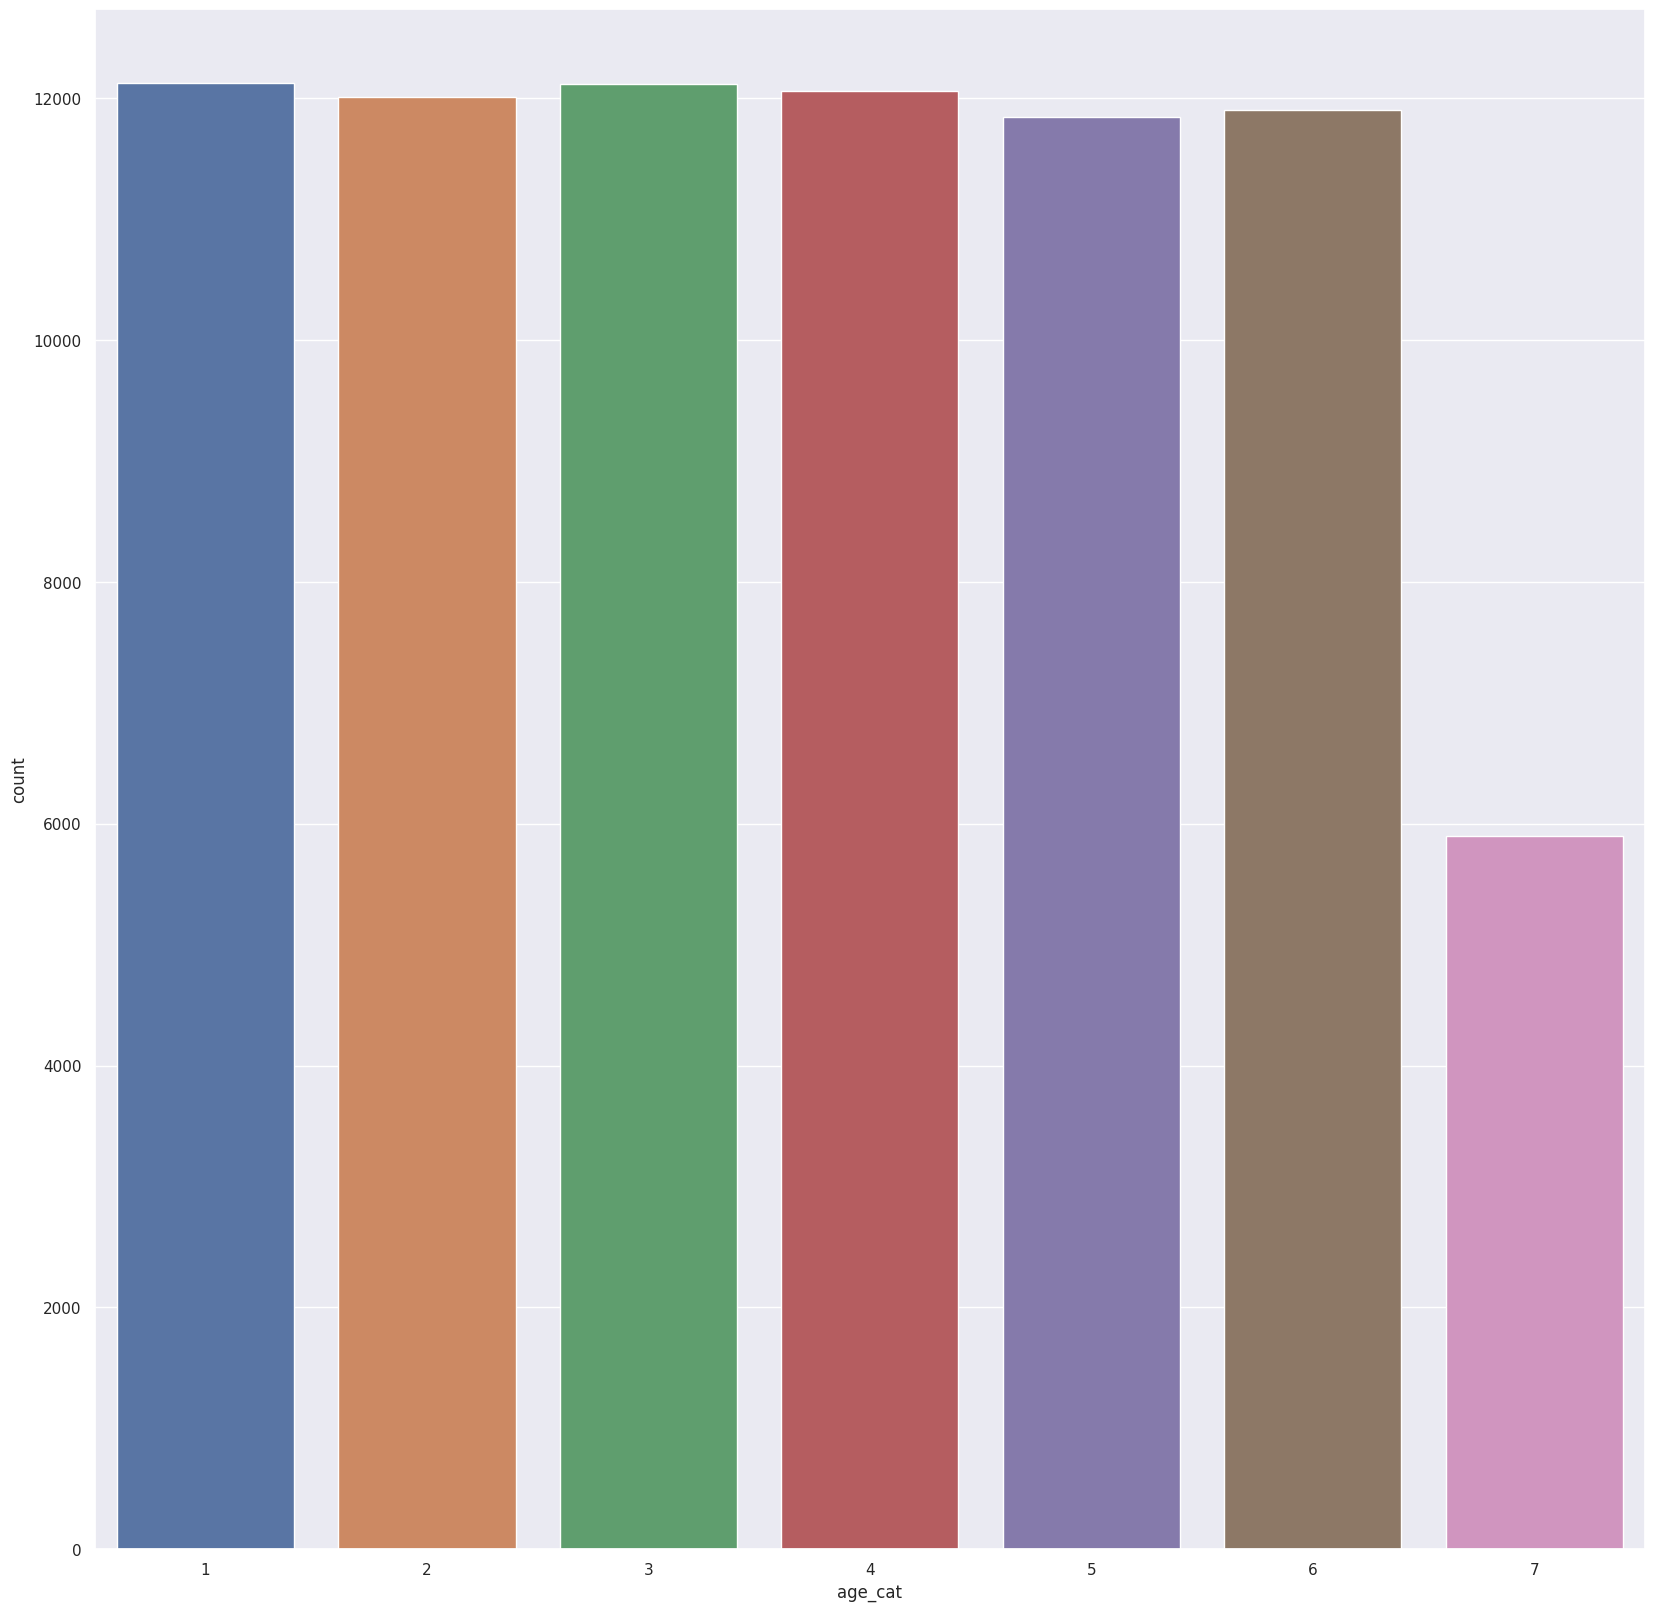

In [236]:
copy_dev_df.sort_values(by='age_cat', ascending=True)
sns.countplot(x = 'age_cat',
              data = copy_dev_df)

sns.set(rc={'figure.figsize':(20,20)})

We observed that there is a big difference between the number of cash payments and debit_card payments. We will tackle this issue by using a stratified k fold when splitting up the train and the validation sets. By this we will eliminate the chance of having just cash payments in one of the sets.

<Axes: xlabel='payment_method', ylabel='count'>

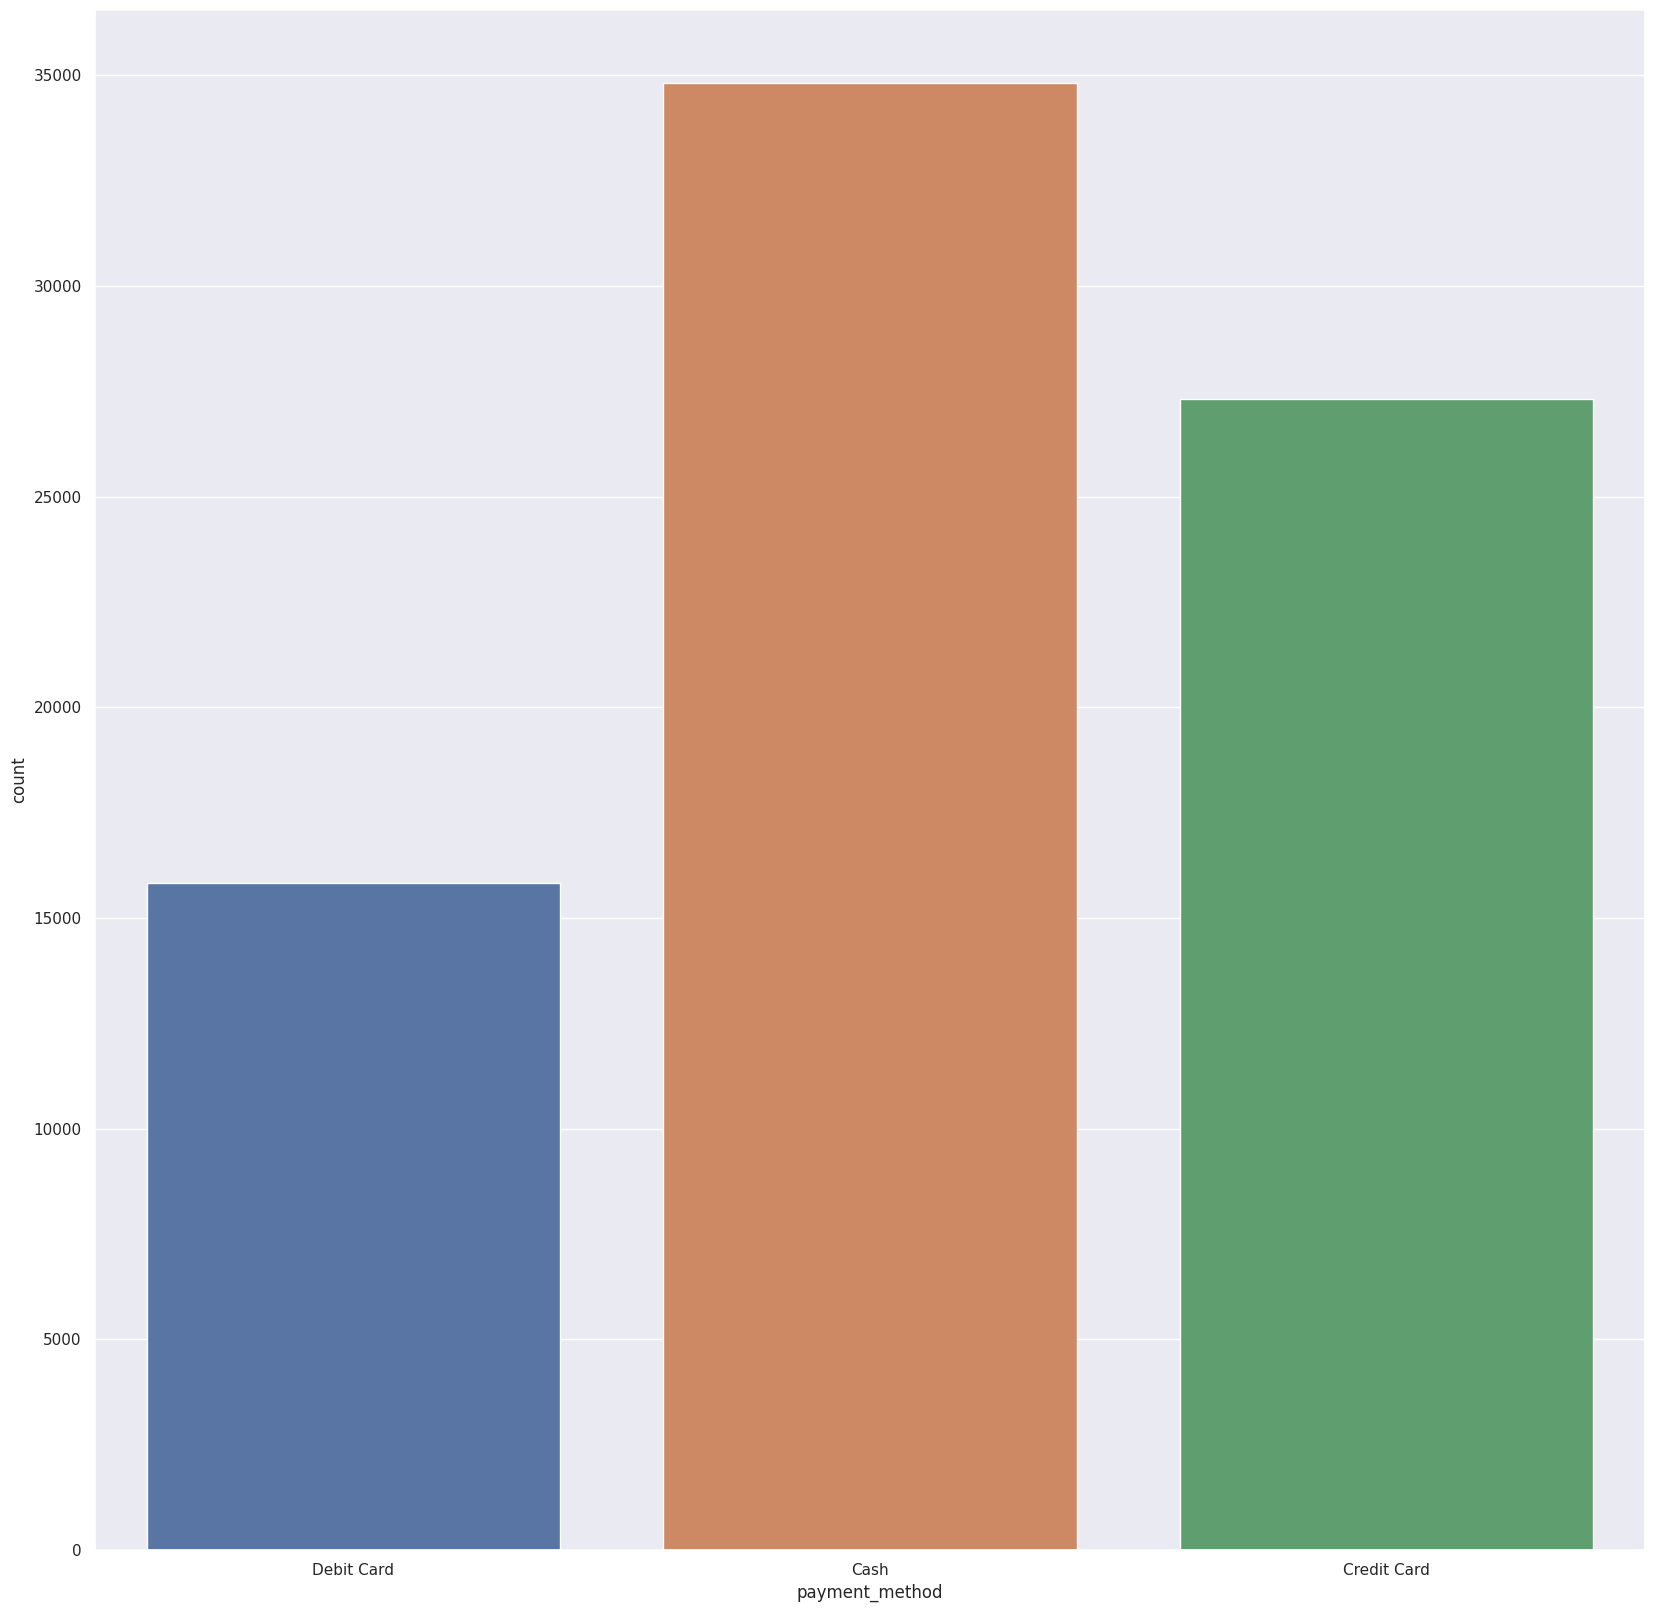

In [237]:
copy_dev_df.sort_values(by='payment_method', ascending=True)
sns.countplot(x = 'payment_method', data = copy_dev_df)

<p> 
    Next, we ploted the number number of payments made by all three payment methods along the price axis. From this we conluded that there are only a few payments above 3000. So we should remove the examples above 3250.
</p>

<Axes: xlabel='price'>

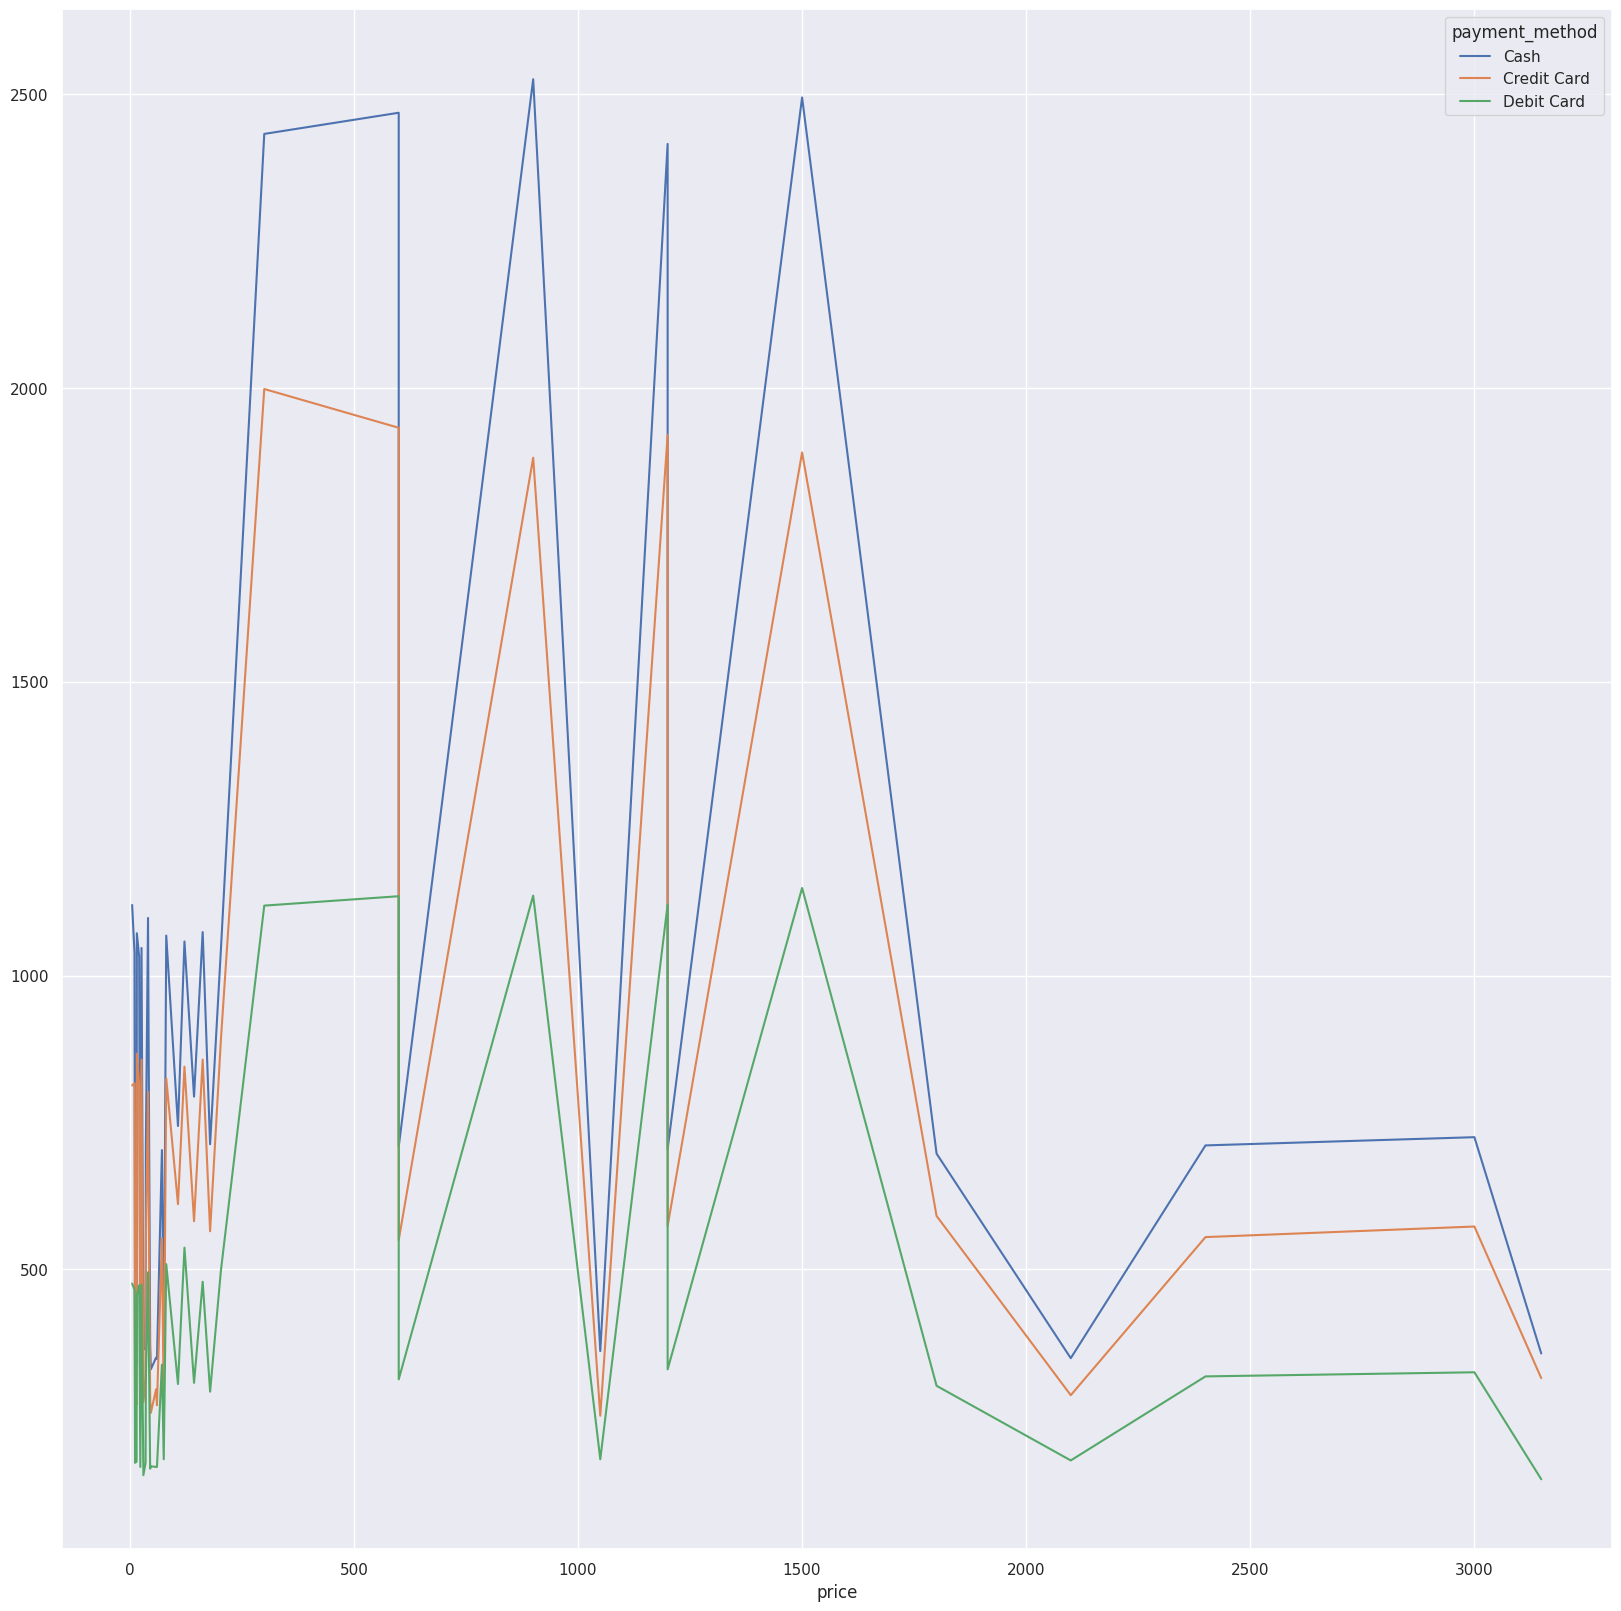

In [238]:
# Create a pivot table to capture the payment methods used along prices
age_payment_method_combined = copy_dev_df.pivot_table(index='price', columns='payment_method', aggfunc='count')['age']
# Plot the table
age_payment_method_combined.plot.line()

From this plot we can see the cause of the steep peeks and drops. The amount of the payment is not evenly distributed (we don't have a continuity in prices).

<Axes: xlabel='price'>

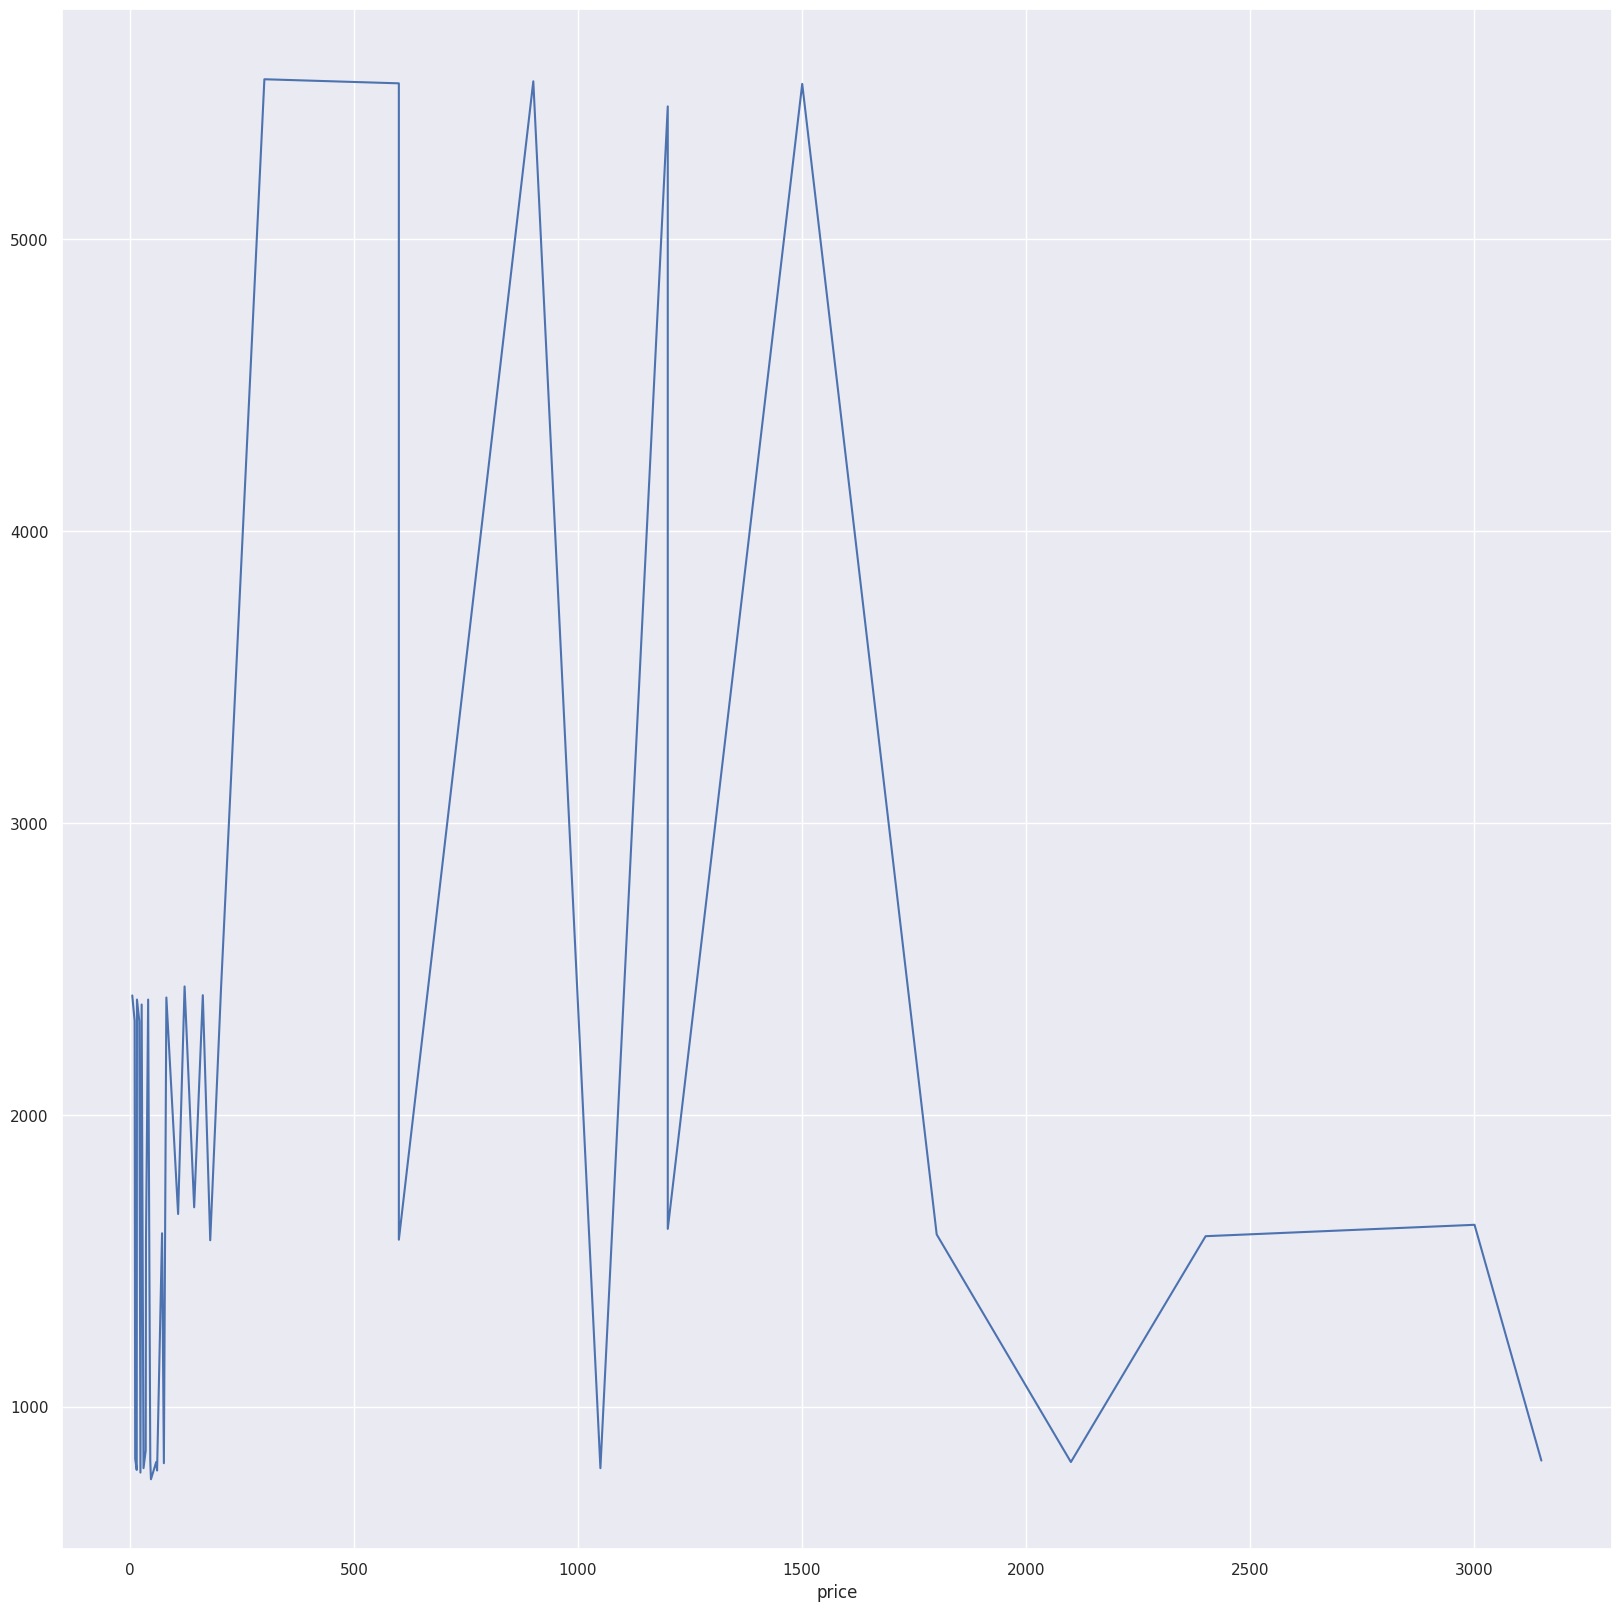

In [239]:
price_count = copy_dev_df.groupby('price').count()['gender']
price_count.plot.line(x = 'price', y = 'gender')

<p>
    We can observe that there is are many transactions at the beginning of the year, there is a peak in the summer (maybe this can be a period when there are more tourists in the city), but a low point around september. The peak at the beginning of the year is very interesting, because at the end of the year there isn't a climbing tendency that would assure continuity along the timeline.
</p>

<Axes: xlabel='month', ylabel='count'>

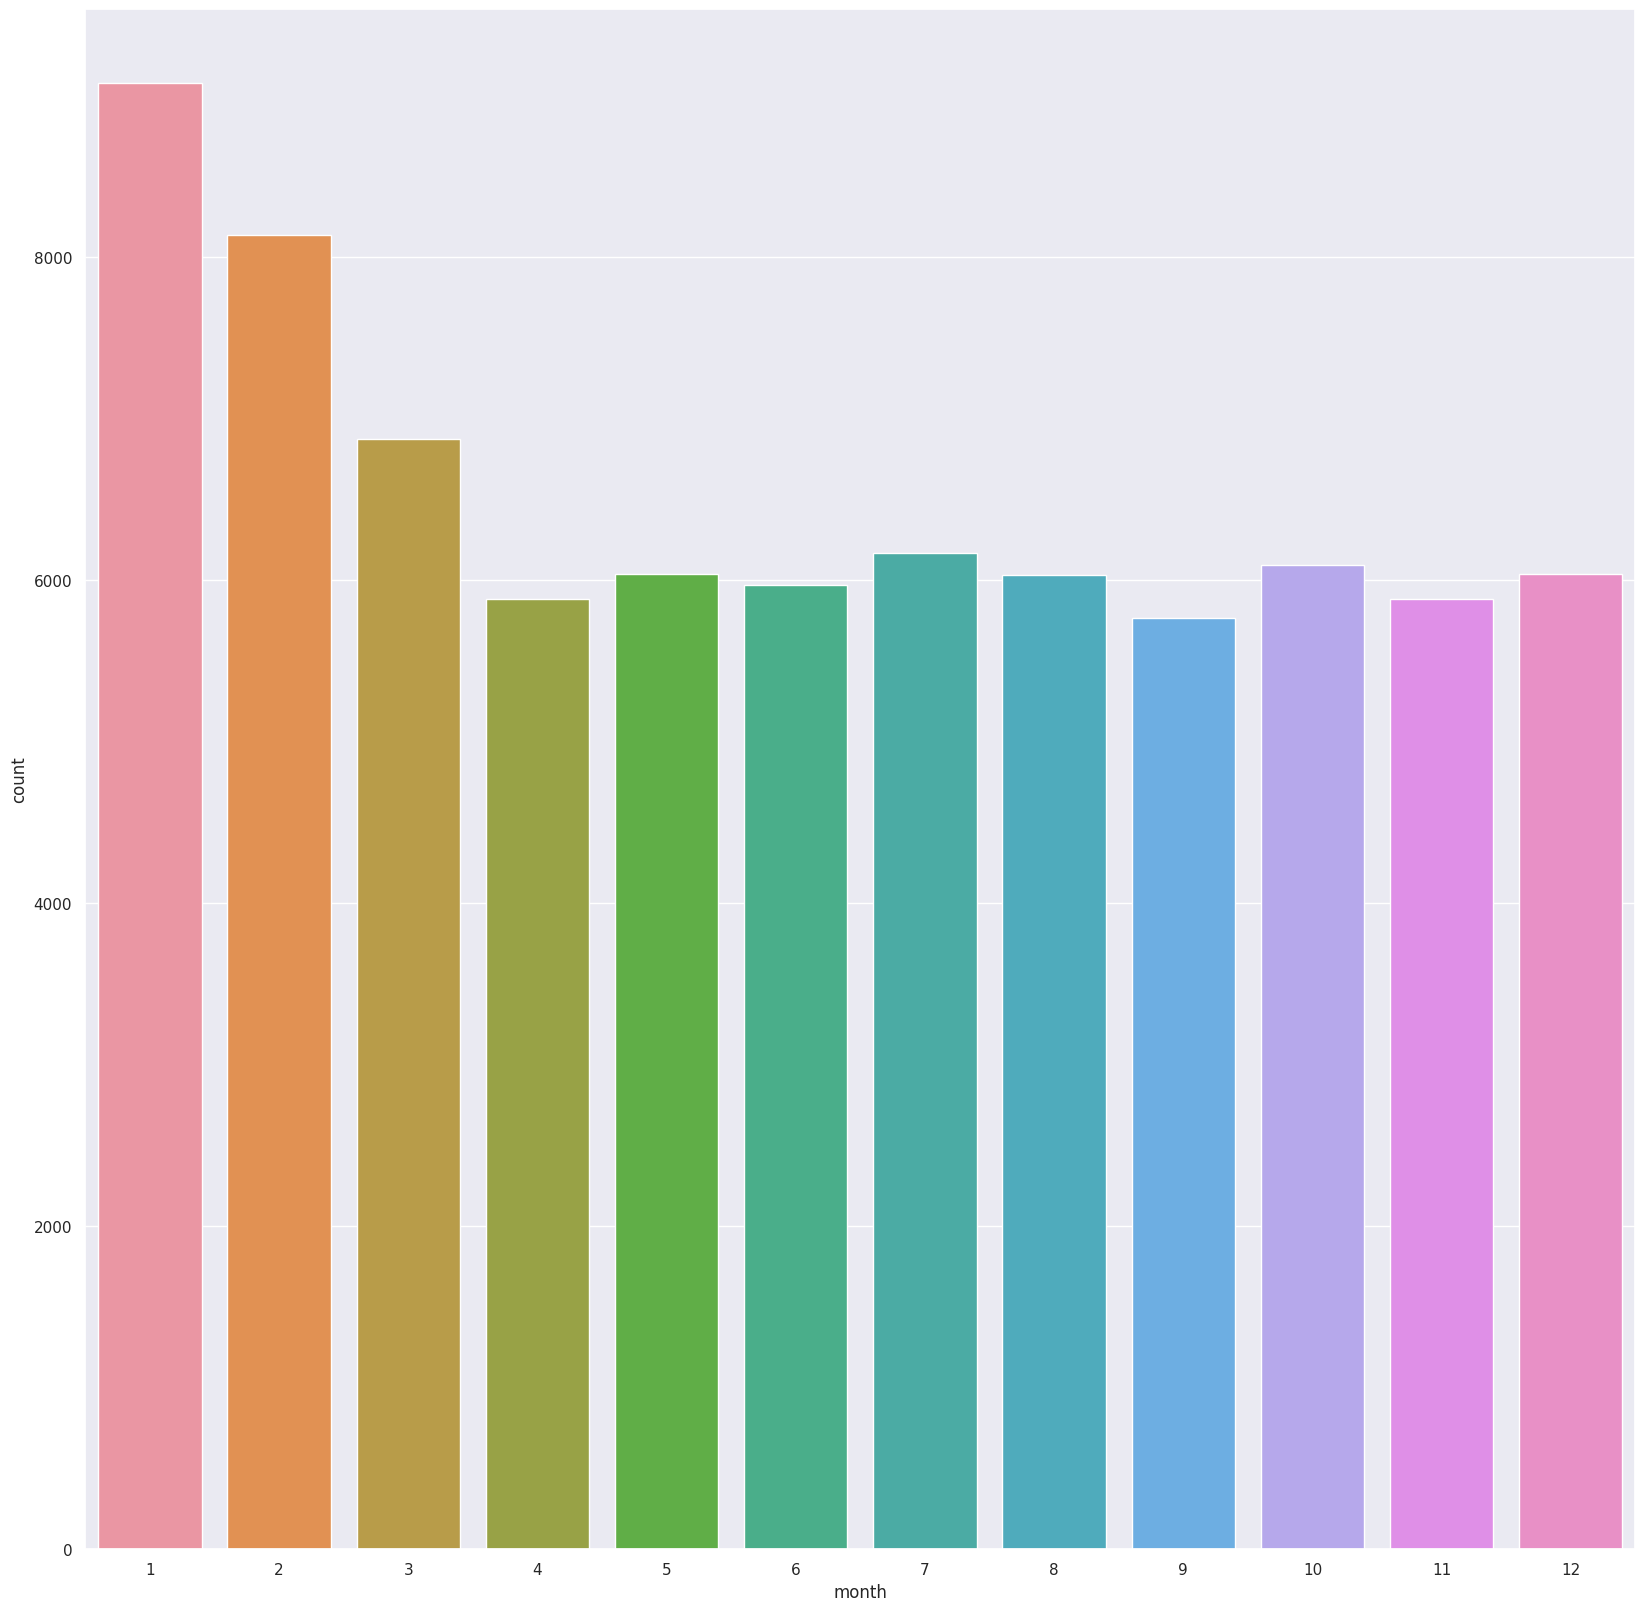

In [240]:
sns.countplot(x = 'month',
              data = copy_dev_df)

<p>
    The count of each payment type along with the months.
</p>

<Axes: xlabel='month'>

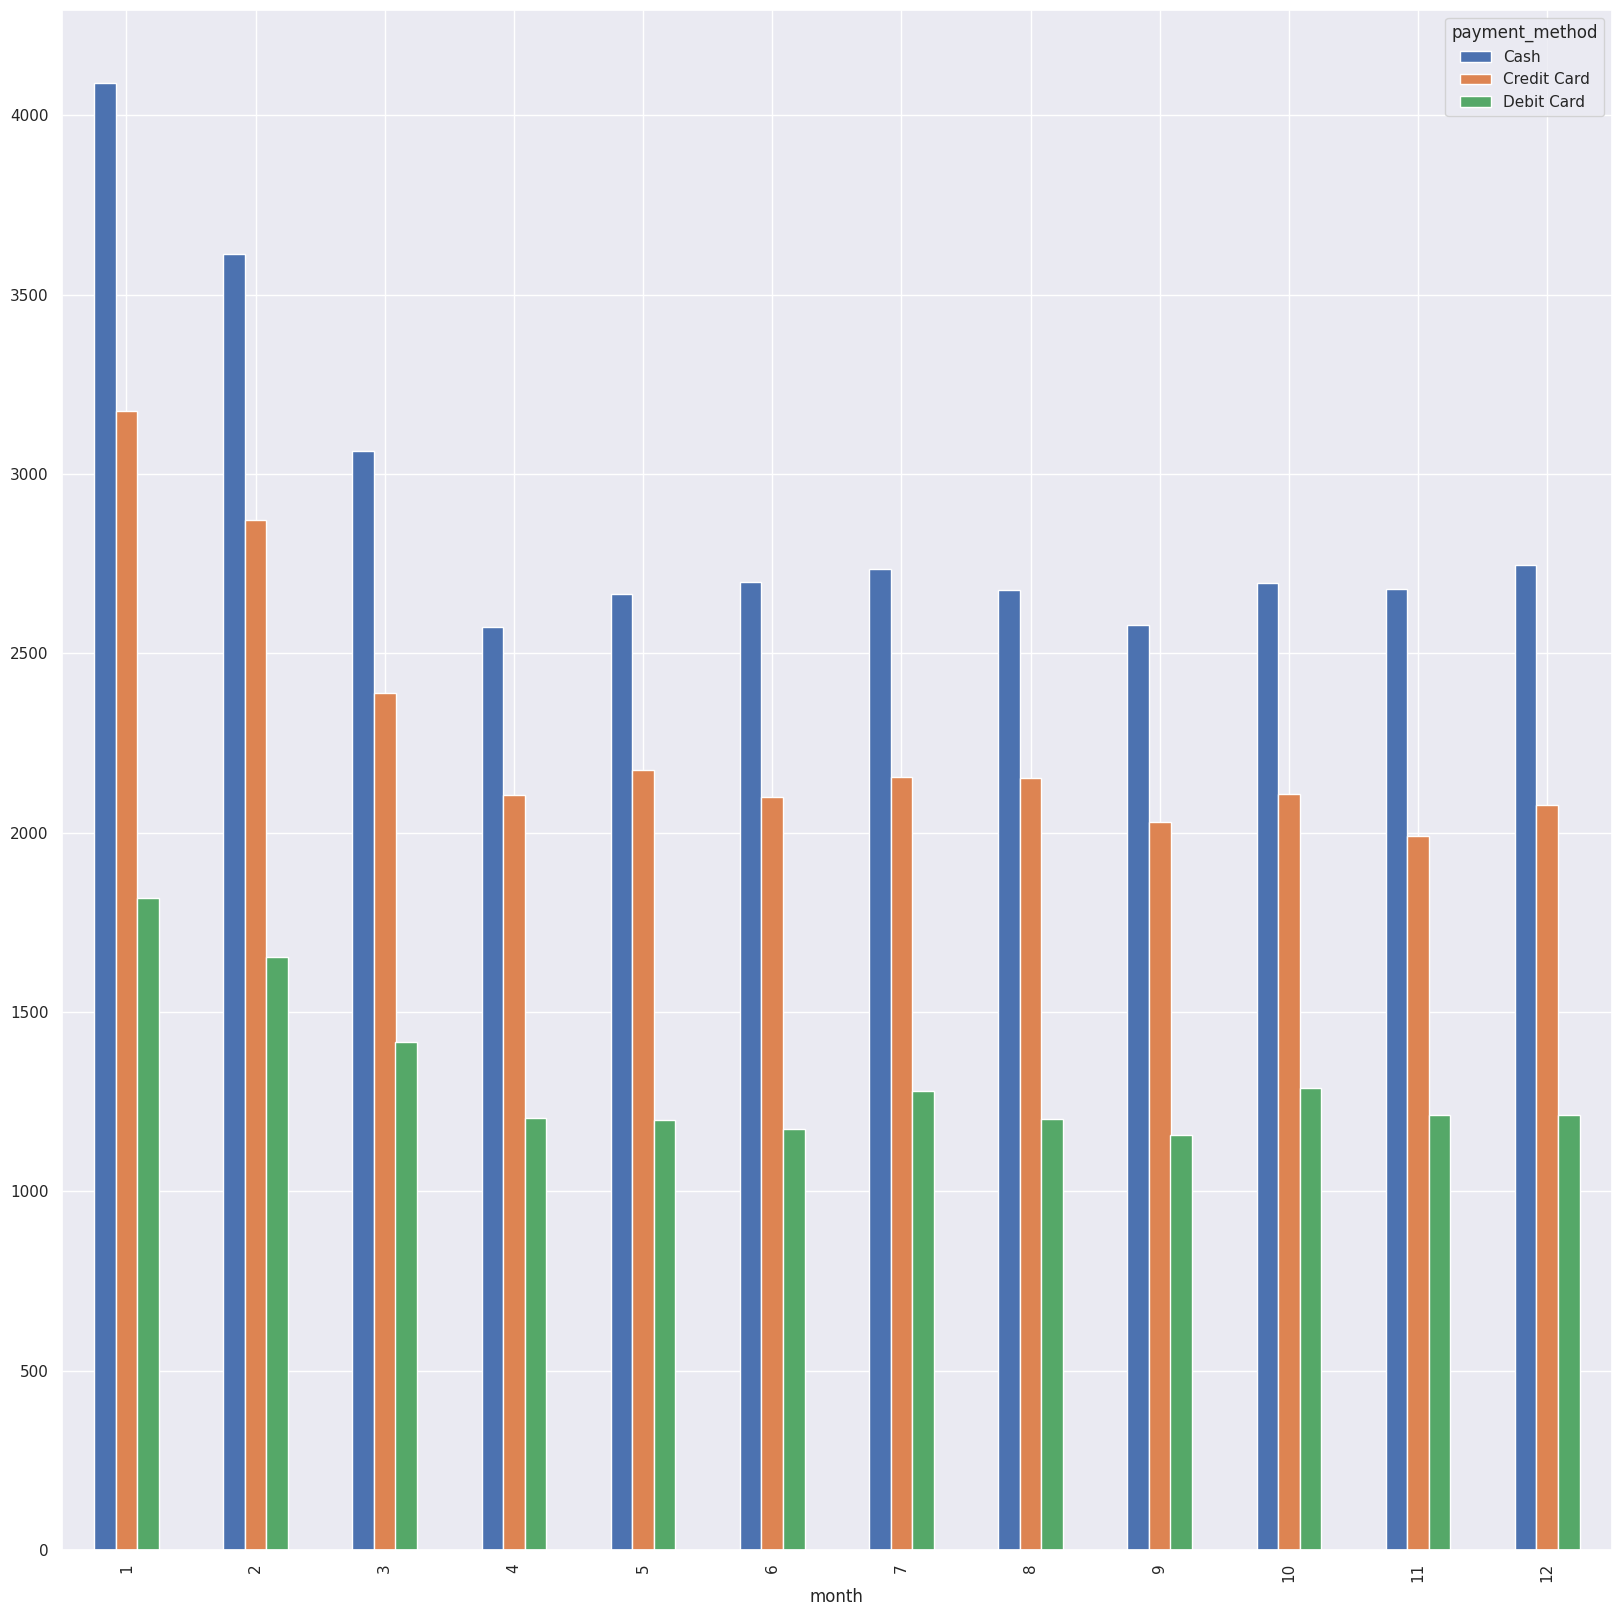

In [241]:
# Create a pivot table to capture the payment methods used for each age category
month_payment_method = copy_dev_df.pivot_table(index='month', columns='payment_method', aggfunc='count')['age']
# Plot the table
month_payment_method.plot.bar()

<p>
    It can be seen a small increase in correlation between the the payment method, specifically payments made by debit card and age, also the period of the year seems to be slightly more corellated with the payment method. Based on these observations we will make feature engineering. Also because of this small corelation we expect low performance values of the models, unfortunately.
</p>

In [242]:
copy_dev_df['payment_method_cat'] = 0
copy_dev_df.loc[copy_dev_df['payment_method'] == 'Cash','payment_method_cat'] = 1
copy_dev_df.loc[copy_dev_df['payment_method'] == 'Debit Card','payment_method_cat'] = 2
copy_dev_df.loc[copy_dev_df['payment_method'] == 'Credit Card','payment_method_cat'] = 3

corr_matrix = copy_dev_df.corr()
corr_matrix['payment_method_cat'].sort_values(ascending=False)

/tmp/ipykernel_16839/534144293.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = copy_dev_df.corr()


payment_method_cat    1.000000
age_cat_4             0.004589
age_cat_7             0.004370
quantity              0.003329
age_cat_1             0.002929
price                 0.001626
age_cat              -0.000038
age_cat_5            -0.000125
age                  -0.000178
age_cat_3            -0.001093
age_cat_2            -0.004270
year                 -0.004317
month                -0.004850
age_cat_6            -0.005265
Name: payment_method_cat, dtype: float64

<h3> Feature engineering</h3>

<p>We decided to introduce a relationship between the month and the price because we saw that these columns have an outstanding importance in the decision tree.
</p>

In [243]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

<Axes: xlabel='price', ylabel='month_x_price'>

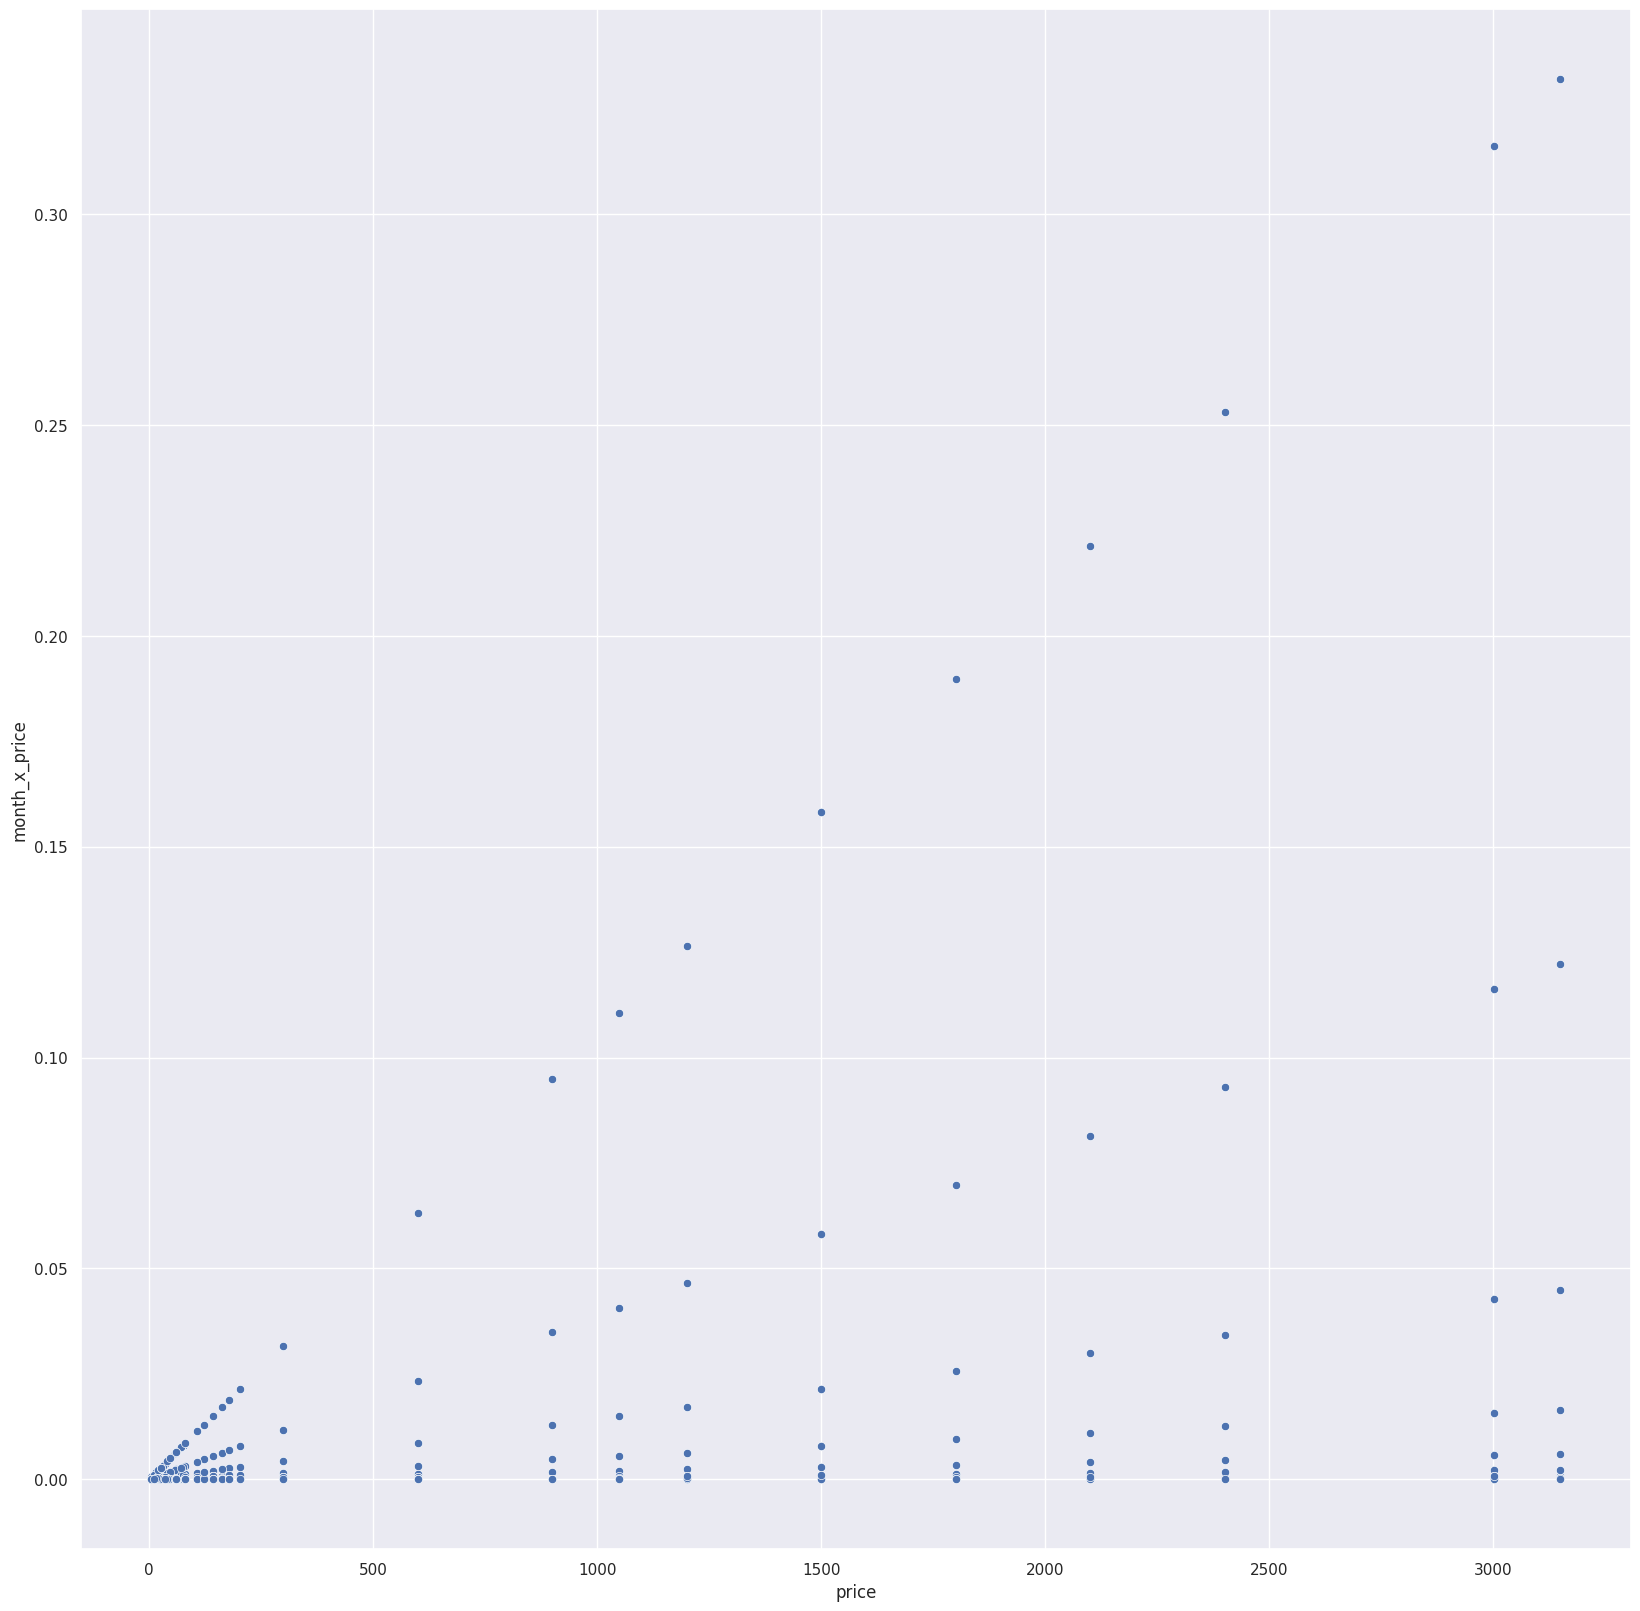

In [265]:
from scipy.special import softmax
copy_dev_df['month_x_price'] = softmax(copy_dev_df['month'])*copy_dev_df['price']
scatterplot(x = "price", y = "month_x_price",data=copy_dev_df)

<h3> Data preprocessing </h3>

In [267]:
numeric_features = ['quantity','price','age_cat_1','age_cat_2','age_cat_3','age_cat_4','age_cat_5','age_cat_6','age_cat_7', 'year', 'month', 'mall_category','month_x_price']
nominal_features = ['gender','category']

features = ['quantity','price','age_cat_1','age_cat_2','age_cat_3','age_cat_4','age_cat_5','age_cat_6','age_cat_7', 'year', 'month', 'mall_category','gender','category','month_x_price']
target_value = ['payment_method']

<p>
    We made a preprocessor that imputes eventual missing numerical values to the mean (even thought we could not observe values that were missing), and applies a standardization on the numerical values. The standardization can improve the results of logistic regression.
</p>
<p> 
    On the nominal values we applied one hot encoder, because we didn't have many distinct values for them.
</p>

In [268]:
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(missing_values=np.nan,strategy="mean")),
        ("scaler", StandardScaler())
    ]), numeric_features),
    ("nom", Pipeline([
        ("binarizer", OneHotEncoder(handle_unknown="ignore"))
    ]), nominal_features)    
], remainder = "passthrough")

<h3> Model building </h3>

<p>
    The next step was to separate the features from the target value, and build a splitter that creates 5 sub-sets of the original training set and also preserves the ratios of the examples belonging to the target values. Even thought we had plenty of examples we thought that by making sub-sets and training on them would reduce the overfitting.
</p>

In [269]:
from sklearn.model_selection import StratifiedKFold
# Add the new feature into the test set too
test_df['month_x_price'] = softmax(test_df['month'])*test_df['price']

# Separate the features from the target value
dev_X = copy_dev_df[features]
test_X =  test_df[features]

dev_y = copy_dev_df['payment_method'].values
test_y = test_df['payment_method'].values

splitter = StratifiedKFold(n_splits = 5) 

<p>
    After that we started building the models, and see which one performed the best.
</p>
<p>
    Our first choice was the <b>Random Forest Classifier</b>, we expected the best results from this classifier, as we knew it performs better than a simple Decision Tree (because it compiles the knowledge of more Decision Trees). At first we chose a loss function named f1_macro, this loss function calculates the F1 score, which is the harmonic mean of precision and recall, for each class separately and then takes the average across all classes. The Grid Search gives as best parameter the 40 decision trees and the max depth of 40. For us the depth of 40 seems a bit too much, we are afraid of overfitting.
</p>

In [248]:
# Make a pipeline that contains the preprocessor and the regressor
rf = Pipeline([
    ("preprocessor",preprocessor),
    ("predictor",RandomForestClassifier(random_state=42))
])

# Give the possible values to the hyperparameter
rf_params = {"predictor__n_estimators": [10,40,75,100],
             "predictor__max_depth": [5,10,40,80]}

# Create a GridSearch to find the best value for the hyperparameter using the two sets 
# of data (training and validation) given by the splitter
rf_gs = GridSearchCV(rf, rf_params, scoring="f1_macro", cv=splitter, refit=True)
# Run the grid search
rf_gs.fit(dev_X, dev_y)

# Display the result
rf_gs.best_params_, rf_gs.best_score_

({'predictor__max_depth': 40, 'predictor__n_estimators': 40},
 0.32821159232500696)

<p>
    As the f1_macro function puts the same weight on each class, it is not good to use for multi-class classification, to address this issue we switched to f1_weighted loss function. This loss function assigns a weight for the classes based on the number of each class in the dataset. Interestingly this loss function results in different hyperparameters as best. It increasis the performance of the model, but <i> it is still far from being good.</i>
</p>

In [249]:
rf_gs = GridSearchCV(rf, rf_params, scoring="f1_weighted", cv=splitter, refit=True)

rf_gs.fit(dev_X, dev_y)

rf_gs.best_params_, rf_gs.best_score_

({'predictor__max_depth': 40, 'predictor__n_estimators': 75},
 0.3660726482633381)

<p>We wanted to see which features are considered when building a tree, and their importance. Therefore we build a decision tree of height 5 and printed it.</p> 
<p>When we ran the decision tree for the first time there were some interesting decisions made (after that we made the feature engineering and the nodes in the tree changed). Firstly, based on gender, if the example was a female the very next decision it made was whether she buys cosmetics, or not. Further down the tree it played a significant role the age of the example, and in which period of the year it purchased. On the other hand, in case of male examples it was more based on the year it was in, the age and the category (bought books and tech related products or not). We thought it would be interesting to share this insight.</p>
<p>
    In the current shape of the tree, one cannot tell how the decision was made, because of the weak correlation between the features and the target value.
</p>

In [253]:
preprocessor.fit(dev_X,dev_y)
preprocessor.get_feature_names_out()

array(['num__quantity', 'num__price', 'num__age_cat_1', 'num__age_cat_2',
       'num__age_cat_3', 'num__age_cat_4', 'num__age_cat_5',
       'num__age_cat_6', 'num__age_cat_7', 'num__year', 'num__month',
       'num__mall_category', 'num__month_x_price', 'nom__gender_Female',
       'nom__gender_Male', 'nom__category_Books',
       'nom__category_Clothing', 'nom__category_Cosmetics',
       'nom__category_Food & Beverage', 'nom__category_Shoes',
       'nom__category_Souvenir', 'nom__category_Technology',
       'nom__category_Toys'], dtype=object)

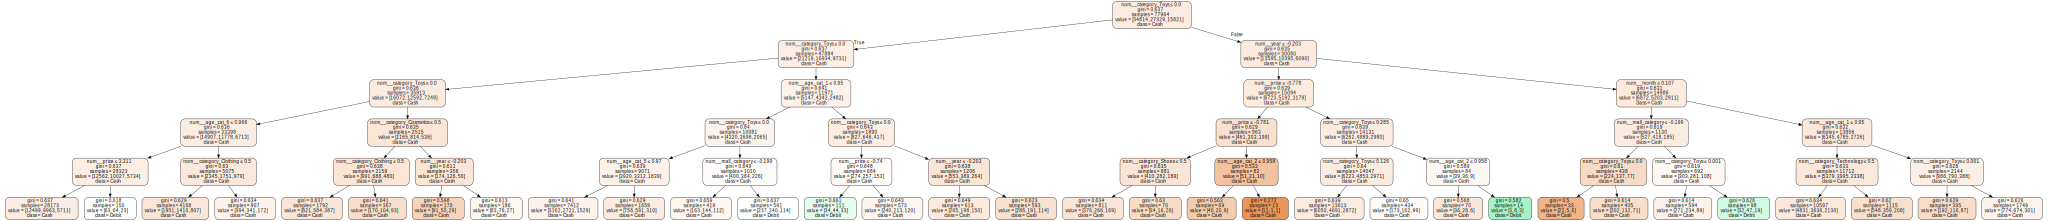

In [254]:
from sklearn.tree import export_graphviz
import graphviz 

dt.fit(dev_X, dev_y)

dot_data = export_graphviz(dt.named_steps['classifier'], out_file=None,
                           feature_names=preprocessor.get_feature_names_out(), class_names=['Cash','Debit','Credit'],
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('decision_tree', format='png')
graph

<p>
    As the next step we printed the importance of the features in the decision tree.
</p>
<p>
    The most important in the decision was the period and the price of the purchase.
</p>

In [256]:
# Extract feature importances from the decision tree model
importances = dt.named_steps['classifier'].feature_importances_

# Get the names of the preprocessed features
features = preprocessor.get_feature_names_out()

# Create a dictionary of feature names and importances
feature_importances = dict(zip(features, importances))
sorted_dict = dict(sorted(feature_importances.items(), key=lambda item: item[1]))

# Print the feature importances as text
for feature, importance in sorted_dict.items():
    print(f"{feature}: {importance}")

num__quantity: 0.0
num__age_cat_3: 0.0
num__age_cat_4: 0.0
num__age_cat_7: 0.0
num__month_x_price: 0.0
nom__gender_Female: 0.0
nom__gender_Male: 0.0
nom__category_Books: 0.0
nom__category_Food & Beverage: 0.0
nom__category_Souvenir: 0.0
nom__category_Shoes: 0.015720542355031123
num__month: 0.027522256346379306
num__age_cat_5: 0.02858611112167634
nom__category_Technology: 0.028944260930532668
nom__category_Cosmetics: 0.028984744008798847
num__age_cat_6: 0.03312569833141959
num__age_cat_2: 0.04311166154663239
nom__category_Clothing: 0.04326803673410202
num__age_cat_1: 0.0542160956819919
num__mall_category: 0.09306208599605074
num__year: 0.10453571703121389
num__price: 0.11975758978840116
nom__category_Toys: 0.3791652001277701


<p>The next model we build was based on <b>Logistic Regression</b>. Despite the fact that the result less explainable, than in case of decision trees, it gave a better result, than the previous 2 models.</p>
<p>
    Also the l2 regularization did not converge. This might be because it is trying to minimize the loss function while also tries to keep the weights small, which can result in weights that are too small and don't have enough predictive power. 
</p>

In [257]:
from sklearn.linear_model import LogisticRegression
# Make a pipeline that contains the preprocessor and the regressor
lr = Pipeline([
    ("preprocessor",preprocessor),
    ("predictor",LogisticRegression(solver='saga'))
])

# Give the possible values to the hyperparameter
lr_params = {"predictor__penalty": ['l1','l2'],
             "predictor__C": [0.1, 0.3, 0.5]}

# Create a GridSearch to find the best value for the hyperparameter using the two sets 
# of data (training and validation) given by the splitter
lr_gs = GridSearchCV(lr, lr_params, scoring='accuracy', cv=splitter, refit=True)
# Run the grid search
lr_gs.fit(dev_X, dev_y)

# Display the result
lr_gs.best_params_, lr_gs.best_score_

/home/zoli/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/zoli/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/zoli/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/zoli/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/zoli/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/zoli/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Convergen

({'predictor__C': 0.1, 'predictor__penalty': 'l1'}, 0.4465394289125473)

<p>
    To have a reference value we created also a <b>Dummy Classifier</b>. We gave it the strategy to predict based on the distribution of the classes in the training data.
</p>
<p>
    To our surprise the RandomForestClassifier did not perform better than pure chance, but to our happiness, the LogisticRegression outperformed the dummy classifier. 
</p>

In [258]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy = DummyClassifier(strategy='stratified')
dummy.fit(dev_X,dev_y)

y_pred = dummy.predict(dev_X)

accuracy_score(dev_y, y_pred)

0.36383459032373916

<h3> Check the model on the test set </h3>

<p>
    The accuracy on the test set (which it never saw) matches the accuracy on the development set. This means that this is the true accuracy of the model, and it was not biased by the training set.
</p>

In [270]:
accuracy_score(test_y, lr_gs.predict(test_X))

0.4479503360525371

<h3> Conclusion </h3>

<p>
    The accuracy result of the model let us down a bit, at the beginning we had a high expectation from it, even more it seemed a clean dataset. However, we shortly realised we will have some problems based on our columns. It was hard to see the correlation between the payment method type and the features. But we still hoped in the timestamp, the price and the mall the purchase was made from (which turned out not to be as important as we thought).
</p>
<p>
    After the data visusalization part it was pretty clear we will have a hard time. We could not see a strong correlation between the numerical features, and the conrrelation matrix showed that as well.
</p> 
<p>
    Despite these facts, the logistic regressor gave an accuracy higher than the dummy classifier. Which cheered us up a bit.
</p>